# Basic Hands-On 1: Neural networks for regression - simple energy reconstruction with TA

In this example, we want to do a reconstruction for a detector such as TA surface array.  As we just saw in the previous examples, we want to estimate a quantity in reality from many different features. Here, the two features are total signal and arrival times, which are located in two different files. The TA reconstruction framework exploits the spatial information of each event by defining a 7x7 tile out of the surface array. We will learn how to visualize the input data and how to move from a fully connected simple network to a convolutional network.


### 1. Load data from ascii file and visualize

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim
from matplotlib.colors import LogNorm

# Set device (GPU if available, mps on Mac, else CPU)
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")


Read data from files. Note that first 5 columns are identical. These are the columns: 
* 0: id  
* 1: energy  
* 2,3,4: shower axis (nx, ny, nz)  
* 5-54: total signal and arrival times. For each event (row), 7x7=49 values. The shape is restored using the `reshape` method.


In [2]:
data_total_signal = np.loadtxt("total_signal_prot.txt", comments="#", dtype=np.float32)
data_arrival_times = np.loadtxt("arrival_times_prot.txt", comments="#", dtype=np.float32)

data = dict()
data["energy"] = data_total_signal[:, 1]
data["shower_axis"] = data_total_signal[:, 2:5]
data["total_signal"] = data_total_signal[:, 5:].reshape(-1, 7, 7)
data["arrival_times"] = data_arrival_times[:, 5:].reshape(-1, 7, 7)

### 2. Investigate numerical data of event with `evt_id`

_Note_: Change evt_id to visualize another event

Each event has a dimension of 7x7-tile within the TA SD array.


In [3]:
evt_id = 59
print(f"Event id={evt_id}")
print(f"\nEnergy={data['energy'][evt_id]} EeV")
print(f"\nShower axis={data['shower_axis'][evt_id]}")
print("\nArrival times")
print(data["arrival_times"][evt_id])
print("\nTotal signal")
print(data["total_signal"][evt_id])

Event id=59

Energy=3.05649995803833 EeV

Shower axis=[ 0.0875133 -0.448413   0.889532 ]

Arrival times
[[    0.      0.      0.      0.      0.      0.      0. ]
 [    0.      0.      0.      0.      0.      0.      0. ]
 [    0.      0.      0.  29439.6 31178.4     0.      0. ]
 [    0.      0.      0.  29119.8 31008.5     0.      0. ]
 [    0.      0.      0.  30448.9     0.      0.      0. ]
 [    0.      0.      0.      0.      0.      0.      0. ]
 [    0.      0.      0.      0.      0.      0.      0. ]]

Total signal
[[ 0.      0.      0.      0.      0.      0.      0.    ]
 [ 0.      0.      0.      0.      0.      0.      0.    ]
 [ 0.      0.      0.     59.4497 64.2563  0.      0.    ]
 [ 0.      0.      0.     76.1689 37.1075  0.      0.    ]
 [ 0.      0.      0.     20.2708  0.      0.      0.    ]
 [ 0.      0.      0.      0.      0.      0.      0.    ]
 [ 0.      0.      0.      0.      0.      0.      0.    ]]


Numbers show which detectors saw a signal. The remaining detectors in the array show values of 0. Visualizing the data before feeding it into a network is crucial. In case of missing entries in the files, we need to assign a 0 or nan/infinity value (depending on your problem). DNNs cannot deal with missing data.

Before we will train a network, let's take a closer look at the data:

### 3. Visualize event: heatmaps of arrival times and total signal

Event id=59

Energy=3.05649995803833 EeV

Shower axis=[ 0.0875133 -0.448413   0.889532 ]

Arrival times
[[    0.      0.      0.      0.      0.      0.      0. ]
 [    0.      0.      0.      0.      0.      0.      0. ]
 [    0.      0.      0.  29439.6 31178.4     0.      0. ]
 [    0.      0.      0.  29119.8 31008.5     0.      0. ]
 [    0.      0.      0.  30448.9     0.      0.      0. ]
 [    0.      0.      0.      0.      0.      0.      0. ]
 [    0.      0.      0.      0.      0.      0.      0. ]]

Total signal
[[ 0.      0.      0.      0.      0.      0.      0.    ]
 [ 0.      0.      0.      0.      0.      0.      0.    ]
 [ 0.      0.      0.     59.4497 64.2563  0.      0.    ]
 [ 0.      0.      0.     76.1689 37.1075  0.      0.    ]
 [ 0.      0.      0.     20.2708  0.      0.      0.    ]
 [ 0.      0.      0.      0.      0.      0.      0.    ]
 [ 0.      0.      0.      0.      0.      0.      0.    ]]


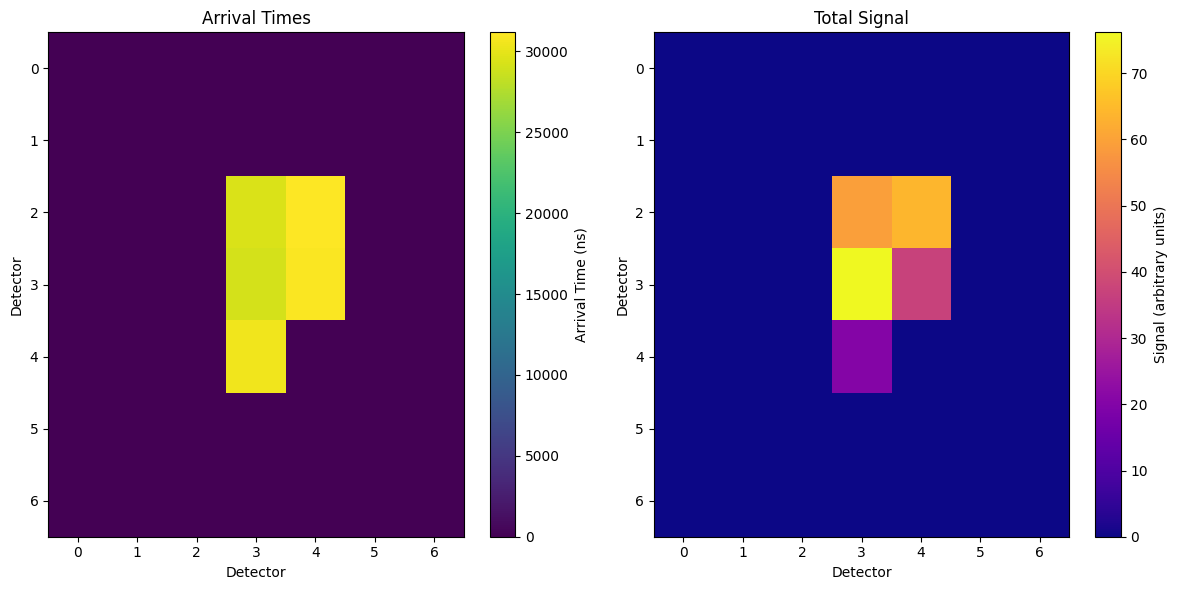

In [4]:
print(f"Event id={evt_id}")
print(f"\nEnergy={data['energy'][evt_id]} EeV")
print(f"\nShower axis={data['shower_axis'][evt_id]}")
print("\nArrival times")
arrival_times = data["arrival_times"][evt_id]
print(arrival_times)
print("\nTotal signal")
total_signal = data["total_signal"][evt_id]
print(total_signal)

# Visualization
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Heatmap for Arrival Times
c1 = axs[0].imshow(arrival_times, aspect="auto", cmap="viridis")
axs[0].set_title("Arrival Times")
axs[0].set_xlabel("Detector")
axs[0].set_ylabel("Detector")
plt.colorbar(c1, ax=axs[0], label="Arrival Time (ns)")

# Heatmap for Total Signal
c2 = axs[1].imshow(total_signal, aspect="auto", cmap="plasma")
axs[1].set_title("Total Signal")
axs[1].set_xlabel("Detector")
axs[1].set_ylabel("Detector")
plt.colorbar(c2, ax=axs[1], label="Signal (arbitrary units)")

plt.tight_layout()
plt.show()

Note: matplotlib has many different colormaps. Choose the most suitable color maps according to your problem. The same data might appear differently in different colormaps.

### 4. Separate data into test and training set

We need to separate the data into a training set and a test set and reshape the data to be used in the network framework. The network cannot handle the 7x7-shaped inputs from two different files (arrays). When you feed data into the neural network model, the 7x7 grid of arrival times and total signals (which is a 2D array) needs to be converted into a 1D array with 49 elements (since 7 × 7 = 49), as we did in the exercises in Basic I. For example, if you have a batch of inputs with the shape (batch_size, 7, 7) (where batch_size is the number of data samples in the batch), you need to "flatten" each 7x7 grid into a 1D vector of length 49 so that the input shape becomes (batch_size, 49).


In [5]:
data["arrival_times"].shape

(51653, 7, 7)

In [6]:
data["total_signal"].shape

(51653, 7, 7)

In [7]:
total_signal = torch.tensor(data["total_signal"], dtype=torch.float32).to(device)
arrival_time = torch.tensor(data["arrival_times"], dtype=torch.float32).to(device)
energy = torch.tensor(data["energy"], dtype=torch.float32).to(device)


In [8]:
# Flatten the arrays to shape (51653, 49)
total_signal_flat = total_signal.view(total_signal.size(0), -1)  # Shape: (51653, 49)
arrival_time_flat = arrival_time.view(arrival_time.size(0), -1)  # Shape: (51653, 49)

In [9]:
arrival_time_flat.shape

torch.Size([51653, 49])

In [10]:
# Combine flattened arrays if needed (e.g., by concatenation)
# Here we can concatenate both arrays if you want to input both features
combined_features = torch.cat((total_signal_flat, arrival_time_flat), dim=1)  # Shape: (51653, 98)

# Split into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(combined_features, energy, test_size=0.2, random_state=42)

# Print shapes to verify
print(f'Train feature shape: {X_train.shape}')  # Should be (41322, 98)
print(f'Test feature shape: {X_test.shape}')    # Should be (10331, 98)
print(f'Train target shape: {y_train.shape}')    # Should be (41322, 1)
print(f'Test target shape: {y_test.shape}')      # Should be (10331, 1)


Train feature shape: torch.Size([41322, 98])
Test feature shape: torch.Size([10331, 98])
Train target shape: torch.Size([41322])
Test target shape: torch.Size([10331])


The data set is very large and we can run out of memory quickly. Therefore, training is often done by iterating over smaller batches of the input data.

In [11]:
from torch.utils.data import Dataset, DataLoader

class CosmicRayDataset(Dataset):
    def __init__(self, X_data, y_data):
        # Store the input features (X_data) and target values (y_data)
        self.X_data = X_data
        self.y_data = y_data

    def __len__(self):
        # Return the total number of samples in the dataset
        return len(self.X_data)

    def __getitem__(self, index):
        # Retrieve a single sample at the given index
        X_sample = self.X_data[index]
        y_sample = self.y_data[index]
        # return torch.tensor(X_sample, dtype=torch.float32), torch.tensor(y_sample, dtype=torch.float32)
        return X_sample, y_sample

# Assuming X_train and y_train are NumPy arrays with shape (N, 7, 7) and (N, 1)
dataset = CosmicRayDataset(X_train, y_train)

In [12]:
batch_size = 64
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [13]:
# illustration of batch training and shapes

for x_batch, y_batch in train_loader:
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([64, 98]) torch.Size([64])


# Exercise 1:  Train and evalulate the model

We are familiar with this step from the previous exercise and will simply take the same model for regression. We can import the class and function, but for better clarity, we will just copy it from the previous day Basic I. Train and evaluate the model performance on the TA data.

In [14]:
# solution
class CosmicRayNN(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2):
        super(CosmicRayNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, 1)  # Output layer

    def forward(self, x):
        x = torch.relu(self.fc1(x))  # Apply ReLU activation
        x = torch.relu(self.fc2(x))  # Apply ReLU activation
        x = self.fc3(x)  # Output layer (no activation)
        return x.squeeze(1)  # Squeeze the output to match the target shape

In [15]:
input_size = 98
hidden_size1 = 64
hidden_size2 = 32
model = CosmicRayNN(input_size, hidden_size1,hidden_size2).to(device) # put model to device, as we always did before

In [16]:
# Define the loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error for regression
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer

# Training function
def train_cosmic_ray_model(model, X_train, y_train, criterion, optimizer, epochs=100):

    dataset = CosmicRayDataset(X_train, y_train)
    batch_size = 128
    train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    model.train()
    losses = []
    for epoch in range(epochs):
        for x_batch, y_batch in train_loader: # loop over every batch
            # Zero gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            
        # Record the loss
        losses.append(loss.item())
            
        # Print loss for every 10th epoch
        if (epoch+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')
        
    return losses


In [17]:
def loss_function_plot(epochs,losses):
    plt.plot(range(epochs), losses)
    plt.title("Loss Curve during Training")
    plt.xlabel("Epochs")
    #plt.yscale('log')
    plt.ylabel("Mean Squared Error Loss")
    plt.show()

Epoch [10/100], Loss: 2463.7627
Epoch [20/100], Loss: 1210.6644
Epoch [30/100], Loss: 1716.8364
Epoch [40/100], Loss: 2381.1777
Epoch [50/100], Loss: 1070.6545
Epoch [60/100], Loss: 2545.4624
Epoch [70/100], Loss: 2740.8293
Epoch [80/100], Loss: 850.3358
Epoch [90/100], Loss: 1544.2935
Epoch [100/100], Loss: 1734.1836


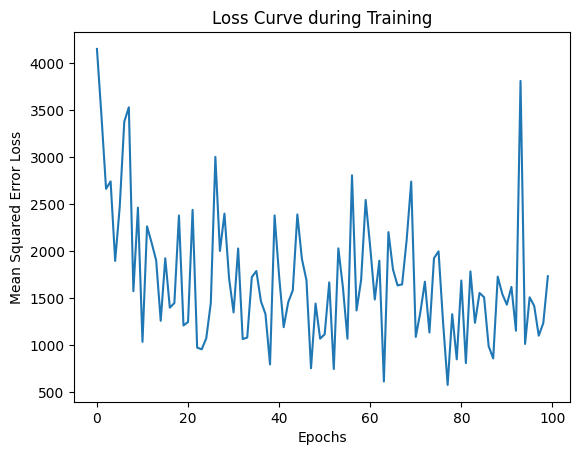

In [18]:
# Train the model and plot the loss curve
epochs = 100
losses = train_cosmic_ray_model(model, X_train, y_train, criterion, optimizer, epochs=epochs)

# Plot the loss curve
loss_function_plot(epochs,losses)

The loss decreases with the number of epochs.

As a final step, we will evaluate the model on a new unseen set of data: the test set.




In [ ]:
# Evaluation function
def evaluate_cosmic_ray_model(model, X_test, y_test, criterion):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Disable gradient calculation for evaluation
        outputs = model(X_test)
        loss = criterion(outputs, y_test)
    print(f'Test Loss: {loss.item():.4f}')
    return outputs

# Evaluate the model on the test set
test_outputs = evaluate_cosmic_ray_model(model.to(device), X_test.to(device), y_test.to(device), criterion)


Test Loss: 2534.1968


The prediction vs true values are usually compared in 2D histogramms. We will plot an example below, calculate median and quantiles.

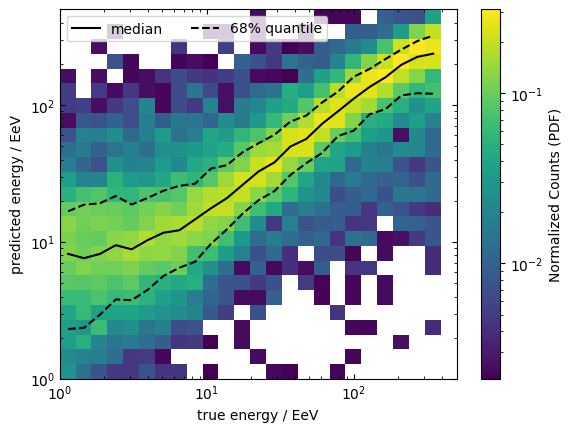

In [20]:
# plot results
bins = np.geomspace(1, 500, 26,endpoint=True)
x = y_test.cpu()
y = test_outputs.cpu()

# Calculate counts for each hexagon
counts, xedges, yedges = np.histogram2d(y_test.cpu(), test_outputs.cpu(), bins=(bins, bins))

# Initialize normalized_counts
normalized_counts = np.zeros_like(counts, dtype=float)

# Perform linear normalization
for i in range(counts.shape[0]):
    max_count = np.sum(counts[i, :]) # loop over row
    if max_count > 0:
        normalized_counts[i, :] = counts[i, :] / max_count

# Calculate median y for each x-bin
median_y_per_xbin = np.zeros(len(bins) - 1)
for i in range(len(bins) - 1):
    y_in_xbin = y[(x >= bins[i]) & (x < bins[i + 1])]
    if len(y_in_xbin) > 0:
        median_y_per_xbin[i] = np.median(y_in_xbin)
    else:
        median_y_per_xbin[i] = np.nan  # Assign NaN if no y values fall in the bin

# Initialize arrays for the 16th and 84th percentiles for each x-bin
y_16th_quantile = np.zeros(len(bins) - 1)
y_84th_quantile = np.zeros(len(bins) - 1)

# Calculate the 16th and 84th percentiles for each x-bin
for i in range(len(bins) - 1):
    y_in_xbin = y[(x >= bins[i]) & (x < bins[i + 1])]
    if len(y_in_xbin) > 0:
        y_16th_quantile[i] = np.percentile(y_in_xbin, 16)
        y_84th_quantile[i] = np.percentile(y_in_xbin, 84)
    else:
        y_16th_quantile[i] = np.nan  # Assign NaN if no y values fall in the bin
        y_84th_quantile[i] = np.nan


fig, ax = plt.subplots()

# plot median
x_bin_mids = (bins[:-1] + bins[1:]) / 2
plt.plot(x_bin_mids,median_y_per_xbin,color='black',label ='median')
plt.plot(x_bin_mids, y_16th_quantile, color='black', ls='--', label=r'68% quantile')
plt.plot(x_bin_mids, y_84th_quantile, color='black', ls='--')

# Create meshgrid for X and Y
X, Y = np.meshgrid(xedges, yedges, indexing='xy')  # Ensure proper indexing

# Plot the hexbin with normalized counts directly
pc = ax.pcolormesh(X, Y, normalized_counts.T, shading='auto',norm=LogNorm())  # Transpose normalized_counts for correct shape

# Add a colorbar
cbar = plt.colorbar(pc, ax=ax)
cbar.set_label('Normalized Counts (PDF)')

# Set scales and labels
# Configure yedges and scales based on ylabel

ax.set_xlabel("true energy / EeV")
ax.set_ylabel("predicted energy / EeV")
ax.set_xscale('log')
ax.set_yscale('log')

ax.legend(loc='upper left',ncol=2)


# Minor ticks and axis configuration
ax.minorticks_on()
ax.tick_params(axis='x', which='both', direction='in', bottom=True, top=True)
ax.tick_params(axis='y', which='both', direction='in', left=True, right=True)


The prediction can still be largely improved. A linear trend is observable between actual and predicted energy, but our simple model has room for improvement. We will revise this task tomorrow after we learn about more complex models.

# Exercise 2: Normalization

Does normalization of the input features (see visualization) improve the estimation?

In [21]:
# Load data again in case some variables have been overwritten
data_total_signal = np.loadtxt("total_signal_prot.txt", comments="#", dtype=np.float32)
data_arrival_times = np.loadtxt("arrival_times_prot.txt", comments="#", dtype=np.float32)

In [22]:
# Store data in a dictionary
data = dict()
data["energy"] = data_total_signal[:, 1]
data["shower_axis"] = data_total_signal[:, 2:5]
data["total_signal"] = data_total_signal[:, 5:].reshape(-1, 7, 7)
data["arrival_times"] = data_arrival_times[:, 5:].reshape(-1, 7, 7)

data["total_signal"] = (data["total_signal"] - data["total_signal"].min()) / (data["total_signal"].max() - data["total_signal"].min())
data["arrival_times"] = (data["arrival_times"] - data["arrival_times"].min()) / (data["arrival_times"].max() - data["arrival_times"].min())

plots for event id 50

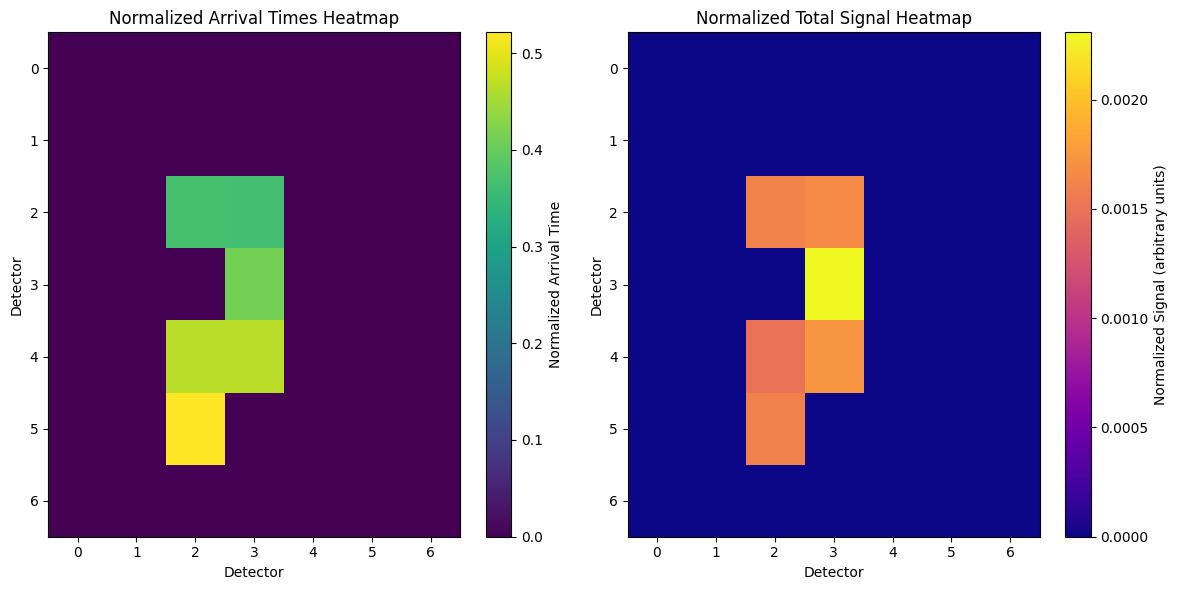

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))


# Heatmap for Normalized Arrival Times
c1 = axs[0].imshow(data["arrival_times"][50], aspect="auto", cmap="viridis")
axs[0].set_title("Normalized Arrival Times Heatmap")
axs[0].set_xlabel("Detector")
axs[0].set_ylabel("Detector")
plt.colorbar(c1, ax=axs[0], label="Normalized Arrival Time")

# Heatmap for Normalized Total Signal
c2 = axs[1].imshow(data["total_signal"][50], aspect="auto", cmap="plasma")
axs[1].set_title("Normalized Total Signal Heatmap")
axs[1].set_xlabel("Detector")
axs[1].set_ylabel("Detector")
plt.colorbar(c2, ax=axs[1], label="Normalized Signal (arbitrary units)")

plt.tight_layout()
plt.show()

In [24]:
total_signal = torch.tensor(data["total_signal"], dtype=torch.float32).to(device)
arrival_time = torch.tensor(data["arrival_times"], dtype=torch.float32).to(device)
energy = torch.tensor(data["energy"], dtype=torch.float32).to(device)


In [25]:
# Flatten the arrays to shape (51653, 49)
total_signal_flat = total_signal.view(total_signal.size(0), -1)  # Shape: (51653, 49)
arrival_time_flat = arrival_time.view(arrival_time.size(0), -1)  # Shape: (51653, 49)

combined_features = torch.cat((total_signal_flat, arrival_time_flat), dim=1)  # Shape: (51653, 98)

# Split into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(combined_features, energy, test_size=0.2, random_state=42)

batch_size = 64
dataset = CosmicRayDataset(X_train, y_train)
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

We use the same model and functions as for the previous exercise:

Epoch [10/100], Loss: 3444.7815
Epoch [20/100], Loss: 2848.5649
Epoch [30/100], Loss: 2518.2754
Epoch [40/100], Loss: 3076.8396
Epoch [50/100], Loss: 2639.4856
Epoch [60/100], Loss: 816.9890
Epoch [70/100], Loss: 1359.1632
Epoch [80/100], Loss: 1756.1255
Epoch [90/100], Loss: 2668.0015
Epoch [100/100], Loss: 3606.4546


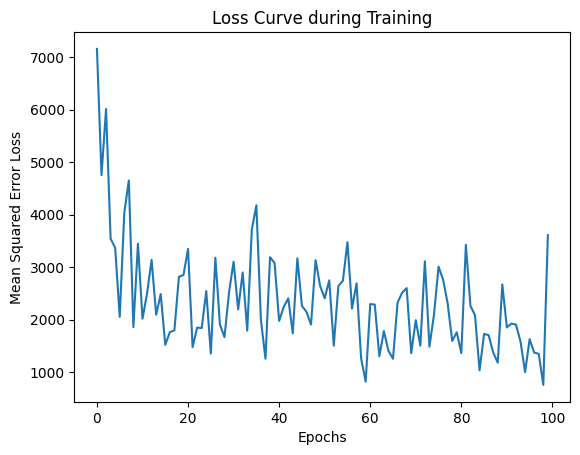

In [26]:
# Train the model and plot the loss curve
epochs = 100
losses = train_cosmic_ray_model(model, X_train, y_train, criterion, optimizer, epochs=epochs)

# Plot the loss curve
loss_function_plot(epochs,losses)

In [27]:
# Evaluate the model on the test set
test_outputs = evaluate_cosmic_ray_model(model.to(device), X_test.to(device), y_test.to(device), criterion)

Test Loss: 1895.2771


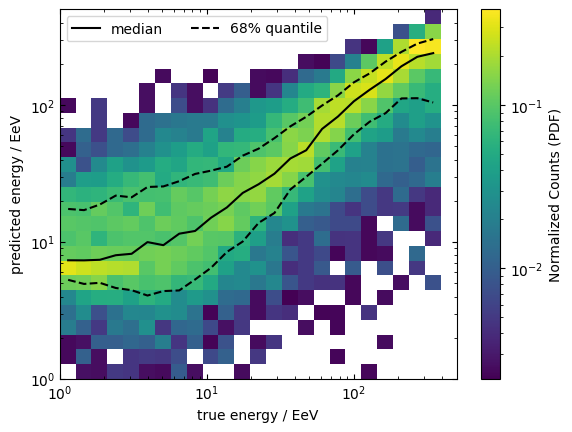

In [28]:
# plot results
bins = np.geomspace(1, 500, 26,endpoint=True)
x = y_test.cpu()
y = test_outputs.cpu()

# Calculate counts for each hexagon
counts, xedges, yedges = np.histogram2d(y_test.cpu(), test_outputs.cpu(), bins=(bins, bins))

# Initialize normalized_counts
normalized_counts = np.zeros_like(counts, dtype=float)

# Perform linear normalization
for i in range(counts.shape[0]):
    max_count = np.sum(counts[i, :]) # loop over row
    if max_count > 0:
        normalized_counts[i, :] = counts[i, :] / max_count

# Calculate median y for each x-bin
median_y_per_xbin = np.zeros(len(bins) - 1)
for i in range(len(bins) - 1):
    y_in_xbin = y[(x >= bins[i]) & (x < bins[i + 1])]
    if len(y_in_xbin) > 0:
        median_y_per_xbin[i] = np.median(y_in_xbin)
    else:
        median_y_per_xbin[i] = np.nan  # Assign NaN if no y values fall in the bin

# Initialize arrays for the 16th and 84th percentiles for each x-bin
y_16th_quantile = np.zeros(len(bins) - 1)
y_84th_quantile = np.zeros(len(bins) - 1)

# Calculate the 16th and 84th percentiles for each x-bin
for i in range(len(bins) - 1):
    y_in_xbin = y[(x >= bins[i]) & (x < bins[i + 1])]
    if len(y_in_xbin) > 0:
        y_16th_quantile[i] = np.percentile(y_in_xbin, 16)
        y_84th_quantile[i] = np.percentile(y_in_xbin, 84)
    else:
        y_16th_quantile[i] = np.nan  # Assign NaN if no y values fall in the bin
        y_84th_quantile[i] = np.nan


fig, ax = plt.subplots()

# plot median
x_bin_mids = (bins[:-1] + bins[1:]) / 2
plt.plot(x_bin_mids,median_y_per_xbin,color='black',label ='median')
plt.plot(x_bin_mids, y_16th_quantile, color='black', ls='--', label=r'68% quantile')
plt.plot(x_bin_mids, y_84th_quantile, color='black', ls='--')

# Create meshgrid for X and Y
X, Y = np.meshgrid(xedges, yedges, indexing='xy')  # Ensure proper indexing

# Plot the hexbin with normalized counts directly
pc = ax.pcolormesh(X, Y, normalized_counts.T, shading='auto',norm=LogNorm())  # Transpose normalized_counts for correct shape

# Add a colorbar
cbar = plt.colorbar(pc, ax=ax)
cbar.set_label('Normalized Counts (PDF)')

# Set scales and labels
# Configure yedges and scales based on ylabel

ax.set_xlabel("true energy / EeV")
ax.set_ylabel("predicted energy / EeV")
ax.set_xscale('log')
ax.set_yscale('log')

ax.legend(loc='upper left',ncol=2)


# Minor ticks and axis configuration
ax.minorticks_on()
ax.tick_params(axis='x', which='both', direction='in', bottom=True, top=True)
ax.tick_params(axis='y', which='both', direction='in', left=True, right=True)


Prediction is better using normalized features. Normalization defines the features within a specific range so that it becomes easier for the network to predict parameters in a given range.